# <font color='red'> Description du projet </font>

## <font color='blue'>Présentation du problème </font>

L’objectif de ce projet est d’estimer **les temps de réponse et de mobilisation** de la Brigade des Pompiers de Londres. La brigade des pompiers de Londres est le service d'incendie et de sauvetage le plus actif du Royaume-Uni  et l'une des plus grandes organisations de lutte contre l'incendie et de sauvetage au monde.

Le premier jeu de données fourni contient les détails de chaque incident traité depuis janvier 2009. Des informations sont fournies sur la date et le lieu de l'incident ainsi que sur le type d'incident traité. Il est composé de deux fichiers

*   LFB Incident data from 2009 - 2017.xlsx
*   LFB Incident data from 2018 onwards.csv

Le second fichier peut-être récupéré à l'aide du lien : 'https://data.london.gov.uk/download/london-fire-brigade-incident-records/f5066d66-c7a3-415f-9629-026fbda61822/LFB%20Incident%20data%20from%202018%20onwards.csv.xlsx' pour avoir la dernière version du fichier. En effet, les données sont mises à jour tous les mois. Il faut compter au moins 7 minutes pour la lecture des données.

<br>

Le second jeu de données contient les détails de chaque camion de pompiers envoyé sur les lieux d'un incident depuis janvier 2009. Des informations sont fournies sur l'appareil mobilisé, son lieu de déploiement et les heures d'arrivée sur les lieux de l'incident. Il est composé de trois fichiers

*   LFB Mobilisation data from January 2009 - 2014.xlsx
*   LFB Mobilisation data from 2015 - 2020.xlsx
*   LFB Mobilisation data from January 2009 - 2014.xlsx

Le dernier fichier peut-être récupéré à l'aide du lien : 'https://data.london.gov.uk/download/london-fire-brigade-mobilisation-records/3ff29fb5-3935-41b2-89f1-38571059237e/LFB%20Mobilisation%20data%202021%20-%202024.xlsx' pour avoir la dernière version du fichier (mise à jour mensuelle). Il faut compter environ 17 minutes pour la lecture des données.

## <font color='blue'> Etapes précédentes </font>

*   1 - Exploration des données : premières analyses, concaténation des différents fichiers puis jointure des 2 types de données (incident / mobilisation)
*   2 - Data visualisation.ipynb : visualisation des données, étude de la variable à prédire (temps de réponse total) en fonction des variables explicatives, création d'un jeu de données pour la modélisation
*   5 - Preprocessing final : création des jeux de données pour la modélisation faite dans ce notebook
*   6 - Modelisation Preproc final - Pred Continue : modélisation de la variable continue `TotalResponseTime_BC`
*  7 - Modelisation Preproc final - Pred 10Cat : modélisation de la variable continue `ResponseTimeCategory`
*  8 - Modelisation Preproc final - Pred 6Cat : modélisation de la variable continue `ResponseTimeCategory2`
*  9 - Modelisation Preproc final - Pred Binary : modélisation de la variable binaire `ResponseTimeBinary`



*Nota Bene* : Les notebooks numérotés 3 et 4 ont été conservés pour montrer un premier travail de modélisation qui a été abandonné par la suite (voir détails ci-dessous)


## <font color='blue'>Etapes dans ce notebook </font>

Dans ce notebook, nous avons déterminé le modèle final pour la variable binaire puis nous avons interprété les résultats.

Pour évaluer nos modèles (et les comparer) nous utilisons l'exactitude, la précision pour chaque classe ainsi que le rappel et le f1-score. Ces mesures sont calculées sur le jeu de données d'entraînement et de test.

*Nota Bene* : dans ce notebook, le jeu de données d'entraînement correspond au regroupement des jeux de données *train* et *validation* utilisés dans les notebooks 6 à 9.

# <font color='red'>1) Préparation de l'environement de travail </font>

## <font color='blue'>Installation des modules </font>

In [ ]:
#!pip install matplotlib
#!pip install Seaborn
#!pip install openpyxl
#!pip install scipy
#!pip install geopandas
#!pip install scikit-learn
#!pip install statsmodels
#!pip install folium
#!pip install plotly
#!pip install --upgrade seaborn
#!pip install jupyter
#!pip install nbformat
#!pip install lightgbm
#!pip install xgboost
#!pip optuna
!pip install lime

## <font color='blue'>Importation des bibliothèques </font>

In [1]:
import pandas as pd  #Pour les dataframe
import numpy as np #Pour le calcul numérique
import datetime as dt # Pour le calcul sur les dates

## Libraries pour les graphiques
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D # graphique 3D
import plotly.express as px  #graphique 3D dynamique
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as offline

## Libraries pour statistiques
# régression linéaire
import statsmodels.api as sm
from statsmodels.formula.api import ols
# tests statistiques
from scipy.stats import shapiro , kstest # tests de sur la normalité de la distributin
from scipy.stats import bartlett # tests sur les variances
from scipy.stats import kruskal #  comparaison des médianes
from scipy.stats import spearmanr
from scipy.stats import loguniform, uniform
from scipy import stats # notamment pour boxplot
# metrics
from sklearn.metrics import f1_score, accuracy_score, make_scorer, classification_report, recall_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix, roc_curve, auc

# Libraries divers
from copy import deepcopy  # gestion des copies

# Pour la séparation du jeu de données
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet, LogisticRegression

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
# import optuna

# Interprétabilité
import lime
import lime.lime_tabular
import shap


# enregistrement / chargement du modèle final
import joblib

## <font color='blue'>Liaison avec le drive (pour travailler sur GoogleColab) </font>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# <font color='red'>2) Données pour la modélisation </font>

## <font color='blue'>2.a) Chargement </font>


Chargement des données depuis GoogleColab

In [ ]:
train = pd.read_csv('/content/gdrive/My Drive/1_Rendu/FinalDatasets/Complete/Train_Step3_Dataset.csv', low_memory=False)
test = pd.read_csv('/content/gdrive/My Drive/1_Rendu/FinalDatasets/Complete/Test_Dataset.csv', low_memory=False)


Chargement des données depuis un emplacement en local

In [ ]:
train = pd.read_csv('../Data/Datapreprocessing/Complete/Train_Step3_Dataset.csv', low_memory=False)
test = pd.read_csv('../Data/Datapreprocessing/Complete/Test_Dataset.csv', low_memory=False)


## <font color='blue'>2.b) Sélection des variables </font>

In [3]:
# X : variable explicative du modele --> on supprime IncidentNumber et les 4 variables à prédire
# y : la variable à prédire est ResponseTimeCategory
X_train = train.drop(columns=['IncidentNumber','ResponseTimeCategory', 'ResponseTimeCategory2', 'ResponseTimeBinary', 'TotalResponseTime_BC'])
y_train = train[['ResponseTimeBinary']]

X_test = test.drop(columns=['IncidentNumber','ResponseTimeCategory', 'ResponseTimeCategory2', 'ResponseTimeBinary', 'TotalResponseTime_BC'])
y_test = test[['ResponseTimeBinary']]


# <font color='red'> 3) Méthodes </font>

Dans la suite de ce notebook, nous utilisons les méthodes définies ici

In [7]:
### evaluation du modèle
# cette méthode calcul les différentes métriques permettant l'évaluation du modèle
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name}")
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred)
    print("accuracy :", np.round(accuracy_score(y_true, y_pred),4))
    print("precision :", np.round(precision,4))
    print("recall :", np.round(recall,4))
    print("f1 score :", np.round(fscore,4))
    print("ROC AUC :", np.round(roc_auc_score(y_true,y_pred),4))


In [ ]:
### estimation des paramètres, prédiction et calcul des métriques d'évaluation
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    y_train = y_train.to_numpy().ravel() if isinstance(y_train, pd.DataFrame) else y_train
    y_test = y_test.to_numpy().ravel() if isinstance(y_test, pd.DataFrame) else y_test
    # Entraînement du modèle
    model.fit(X_train, y_train)

    # Prédiction sur l'ensemble de validation
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Évaluation sur l'ensemble de validation
    print(model_name)
    evaluate_model(y_train, y_pred_train, "Train Dataset")
    print("\n")
    evaluate_model(y_test, y_pred_test, "Test Dataset")

    return y_pred_train, y_pred_test

# <font color='red'> 4) Modélisation
 </font>


Dans cette section, nous entraînons les modèles sélectionnés dans le notebook précédent aux données "finales". Le choix du modèle final est fait à la fin de la section en fonction des mesures obtenues pour chaque modèle.

## <font color='blue'>4.a) Forêt aléatoire </font>

L'accuracy baisse de 2,5% entre le jeu de données d'entraînement et celui de test. Ce modèle correspond à la meilleure accuracy pour le jeu d'entraînement et se place en seconde position pour ce qui est du test.

In [ ]:
rf_model1 = RandomForestClassifier(random_state=42, n_estimators = 200, min_samples_split = 10, min_samples_leaf = 4, max_depth = 20, bootstrap = False)
ypred_train_rf1, ypred_test_rf1 = train_and_evaluate_model(rf_model1, "Optimized Random Forest Regressor #1", X_train, y_train, X_test, y_test)


Optimized Random Forest Regressor #1

Train Dataset
accuracy : 0.8295
precision : [0.845  0.7755]
recall : [0.9291 0.5898]
f1 score : [0.885 0.67 ]
ROC AUC : 0.7594



Test Dataset
accuracy : 0.8045
precision : [0.8274 0.7236]
recall : [0.9133 0.5437]
f1 score : [0.8682 0.6209]
ROC AUC : 0.7285


In [ ]:
feat_imp = pd.DataFrame({'importance': rf_model1.feature_importances_}, index=rf_model1.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

importance
distStd              0.659128
Stat_resp_rep        0.126103
Bor_resp_rep         0.051384
ratioStd             0.038328
Bor_inc_rep          0.028625
inner                0.017560
H1117                0.008127
H26                  0.007816
PropCat_Outdoor      0.007328
Borough_E09000022    0.005001

## <font color='blue'>4.b) Gradient Boosting </font>

In [ ]:
gb_model1 = GradientBoostingClassifier(n_estimators=300, learning_rate=0.0215443469,
                                       subsample=0.875, min_samples_split=0.001, max_depth=7,
                                       max_features=None, random_state=42)
ypred_train_gb1, ypred_test_gb1 = train_and_evaluate_model(gb_model1, "Optimized Gradient Boosting #1",
                                                           X_train, y_train, X_test, y_test)

Optimized Gradient Boosting #1

Train Dataset
accuracy : 0.8043
precision : [0.8267 0.7241]
recall : [0.9147 0.5385]
f1 score : [0.8685 0.6177]
ROC AUC : 0.7266



Test Dataset
accuracy : 0.8025
precision : [0.8245 0.7234]
recall : [0.9148 0.5335]
f1 score : [0.8673 0.6141]
ROC AUC : 0.7242


In [ ]:
feat_imp = pd.DataFrame({'importance': gb_model1.feature_importances_}, index=gb_model1.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

importance
distStd                      0.907233
Stat_resp_rep                0.010189
H26                          0.008834
ratioStd                     0.008333
Bor_inc_rep                  0.007048
Borough_E09000033            0.005393
H1117                        0.005315
PropCat_Outdoor              0.004889
PropCat_Other Residential    0.004668
Borough_E09000022            0.003443

In [ ]:
gb_model2 = GradientBoostingClassifier(n_estimators=400, learning_rate=0.046415888336,
                                       subsample=0.875, min_samples_split=0.0005, max_depth=9,
                                       max_features=25, random_state=42)
ypred_train_gb2, ypred_test_gb2 = train_and_evaluate_model(gb_model2, "Optimized Gradient Boosting #2", X_train, y_train, X_test, y_test)

Optimized Gradient Boosting #2

Train Dataset
accuracy : 0.8095
precision : [0.8321 0.7308]
recall : [0.915  0.5556]
f1 score : [0.8716 0.6313]
ROC AUC : 0.7353



Test Dataset
accuracy : 0.805
precision : [0.828  0.7241]
recall : [0.9132 0.5456]
f1 score : [0.8685 0.6223]
ROC AUC : 0.7294


In [ ]:
feat_imp = pd.DataFrame({'importance': gb_model2.feature_importances_}, index=gb_model2.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

importance
distStd              0.679640
Stat_resp_rep        0.140097
ratioStd             0.038667
Bor_resp_rep         0.038607
Bor_inc_rep          0.012194
inner                0.009532
H26                  0.009176
PropCat_Outdoor      0.007013
Borough_E09000022    0.006739
H1117                0.006316

## <font color='blue'>4.c) XG Boost </font>

In [ ]:
xgb_model1 = XGBClassifier(subsample=0.875, reg_lambda=0.1, reg_alpha=0.01, random_state=42, use_label_encoder=False, n_estimators=300,
                     max_depth=9, learning_rate=0.046415888, gamma=1, colsample_bytree=0.5)
ypred_train_xgb1, ypred_test_xgb1 = train_and_evaluate_model(xgb_model1, "Optimized XGBoost #1",
                                                             X_train, y_train, X_test, y_test)

C:\Users\ADUBOIS\AppData\Local\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning:

[21:50:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Optimized XGBoost #1

Train Dataset
accuracy : 0.8077
precision : [0.8303 0.7281]
recall : [0.9146 0.5502]
f1 score : [0.8704 0.6268]
ROC AUC : 0.7324



Test Dataset
accuracy : 0.8042
precision : [0.8269 0.7239]
recall : [0.9138 0.5417]
f1 score : [0.8681 0.6197]
ROC AUC : 0.7277


In [ ]:
feat_imp = pd.DataFrame({'importance': xgb_model1.feature_importances_}, index=xgb_model1.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

importance
Stat_resp_rep        0.212321
inner                0.133163
distStd              0.099980
Bor_resp_rep         0.054136
Borough_E09000033    0.028585
ratioStd             0.020918
Borough_E09000017    0.018333
PropCat_Outdoor      0.018227
Borough_E09000020    0.017825
H26                  0.017657

In [ ]:
xgb_model2 = XGBClassifier(subsample=0.8125, reg_lambda=0.01, reg_alpha=0.05, random_state=42,
                          use_label_encoder=False, n_estimators=350,
                         max_depth=10, learning_rate=0.046415888, gamma=2, colsample_bytree=0.6,
                         scale_pos_weight=1)
ypred_train_xgb2, ypred_test_xgb2 = train_and_evaluate_model(xgb_model2, "Optimized XGBoost #2",
                                                             X_train, y_train, X_test, y_test)

C:\Users\ADUBOIS\AppData\Local\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning:

[21:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Optimized XGBoost #2

Train Dataset
accuracy : 0.8087
precision : [0.8312 0.73  ]
recall : [0.9151 0.5526]
f1 score : [0.8711 0.629 ]
ROC AUC : 0.7338



Test Dataset
accuracy : 0.8043
precision : [0.8271 0.7237]
recall : [0.9135 0.5425]
f1 score : [0.8682 0.6201]
ROC AUC : 0.728


In [ ]:
feat_imp = pd.DataFrame({'importance': xgb_model2.feature_importances_}, index=xgb_model2.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

importance
Stat_resp_rep        0.228204
inner                0.127924
distStd              0.103423
Bor_resp_rep         0.040650
Borough_E09000033    0.027019
ratioStd             0.020200
H26                  0.017661
Borough_E09000017    0.016673
Borough_E09000020    0.016064
PropCat_Outdoor      0.015525

## <font color='blue'>4.d) LGBM </font>

In [ ]:
lgb_model1 = LGBMClassifier(random_state=42, subsample=0.75, reg_lambda=0.01, reg_alpha=0.1, num_leaves=90, n_estimators=450,
              max_depth=7, learning_rate=0.046415888, colsample_bytree=0.875)
ypred_train_lgb1, ypred_test_lgb1 = train_and_evaluate_model(lgb_model1, "Optimized LightGBM #1", X_train, y_train, X_test, y_test)

C:\Users\ADUBOIS\AppData\Local\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning:

Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "C:\Users\ADUBOIS\AppData\Local\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 227, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\ADUBOIS\AppData\Local\anaconda3\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\ADUBOIS\AppData\Local\anaconda3\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\ADUBOIS\AppData\Local\anaconda3\lib\subprocess.py", line 1440, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(execu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 258908, number of negative: 623148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 383
[LightGBM] [Info] Number of data points in the train set: 882056, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293528 -> initscore=-0.878311
[LightGBM] [Info] Start training from score -0.878311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
feat_imp = pd.DataFrame({'importance': lgb_model1.feature_importances_}, index=lgb_model1.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

importance
distStd                         14756
Bor_inc_rep                      2012
ratioStd                         2002
Stat_resp_rep                    1731
H1117                            1712
PropCat_Non_Residential          1542
Bor_resp_rep                     1329
PropCat_Dwelling                 1308
H26                              1084
PropCat_Other_Residential         805

In [ ]:
lgb_model2 = LGBMClassifier(random_state=42, subsample=0.875, reg_lambda=0, reg_alpha=0.5,
                            num_leaves=80, n_estimators=250, scale_pos_weight=1,
                            max_depth=13, learning_rate=0.1, colsample_bytree=0.95)
ypred_train_lgb2, ypred_test_lgb2 = train_and_evaluate_model(lgb_model2, "Optimized LightGBM #2", X_train, y_train, X_test, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 258908, number of negative: 623148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 383
[LightGBM] [Info] Number of data points in the train set: 882056, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293528 -> initscore=-0.878311
[LightGBM] [Info] Start training from score -0.878311
Optimized LightGBM #2

Train Dataset
accuracy : 0.8078
precision : [0.831  0.7271]
recall : [0.9138 0.5527]
f1 score : [0.8704 0.628 ]
ROC AUC : 0.7332



Test Dataset
accuracy : 0.8043
precision : [0.8277 0.7224]
recall : [0.9126 0.5448]
f1 score : [0.8681 0.6212]
ROC AUC : 0.7287


In [ ]:
feat_imp = pd.DataFrame({'importance': lgb_model2.feature_importances_}, index=lgb_model2.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

importance
distStd                         10254
ratioStd                         1094
Bor_inc_rep                       705
PropCat_Dwelling                  606
PropCat_Non_Residential           566
H1117                             556
Stat_resp_rep                     553
Bor_resp_rep                      499
H26                               452
PropCat_Other_Residential         389

## <font color='blue'>4.e) Résumé </font>


Le tableau ci-dessous résume les mesures obtenues pour les différents modèles sur le jeu de données d'entraînement.



<table>
<tr>
<th>Modèle</th>
<th>Accuracy</th>
<th>Precision_0</th>
<th>Precision_1</th>
<th>Recall_0</th>
<th>Recall_1</th>  
<th>F1score_0</th>    
<th>F1score_1</th>   
<th>AUC ROC</th>
</tr>


<tr>
<td>Forêt aléatoire #1</td>
<td> 0.8295</td>
<td> 0.8450</td>
<td> 0.7755</td>
<td> 0.9291</td>
<td> 0.5898</td>
<td>0.8850</td>
<td> 0.6700</td>  
<td> 0.7594</td>  
</tr>

<tr>
<td> Gradient Boosting #2</td>
<td> 0.8095</td>
<td> 0.8321</td>
<td> 0.7308</td>
<td> 0.9150</td>
<td>0.5556</td>
<td> 0.8716</td>
<td> 0.6313</td>  
<td> 0.7353</td>    
</tr>

<tr>
<td>XG Boost #2</td>
<td> 0.8087 </td>
<td> 0.8312 </td>
<td> 0.7300</td>
<td> 0.9151</td>
<td> 0.5526</td>
<td> 0.8711</td>
<td> 0.6290</td>  
<td>0.7338 </td>    
</tr>    

<tr>
<td>LGBM #2</td>
<td> 0.8078</td>
<td> 0.8310</td>
<td>0.7271 </td>
<td> 0.9138</td>
<td> 0.5527</td>
<td> 0.8704</td>
<td> 0.6280</td>  
<td> 0.7332</td>     
</tr>    

<tr>
<td>XG Boost #1</td>
<td> 0.8077</td>
<td> 0.8303</td>
<td> 0.7281</td>
<td> 0.9146</td>
<td> 0.5502</td>
<td> 0.8704</td>
<td> 0.6268</td>  
<td> 0.7324</td>      
</tr>
    
<tr>
<td>LGBM #1</td>
<td> 0.8061</td>
<td> 0.8294</td>
<td> 0.7244</td>
<td> 0.9134</td>
<td> 0.5479</td>
<td>0.8694 </td>
<td> 0.6239</td>
<td> 0.7306</td>     
</tr>
    
<tr>
<td> Gradient Boosting #1</td>
<td> 0.8043</td>
<td> 0.8267</td>
<td>0.7241 </td>
<td> 0.9147</td>
<td> 0.5385</td>
<td> 0.8685</td>
<td> 0.6177</td>  
<td> 0.7266</td>
</tr>


</br>

Le tableau ci-dessous résume les mesures obtenues pour les différents modèles sur le jeu de données test.

<table>
<tr>
<th>Modèle</th>
<th>Accuracy</th>
<th>Precision_0</th>
<th>Precision_1</th>
<th>Recall_0</th>
<th>Recall_1</th>  
<th>F1score_0</th>    
<th>F1score_1</th>
<th>AUC ROC</th>
</tr>

<tr>
<td>Gradient Boosting #2</td>
<td> 0.8050</td>
<td> 0.8280</td>
<td> 0.7241</td>
<td> 0.9132</td>
<td> 0.5456</td>
<td> 0.8685</td>
<td> 0.6223</td>  
<td> 0.7294</td>      
</tr>

<tr>
<td>Forêt aléatoire #1</td>
<td> 0.8045</td>
<td> 0.8274</td>
<td> 0.7236</td>
<td> 0.9133</td>
<td> 0.5437</td>
<td>0.8682</td>
<td> 0.6209</td>  
<td> 0.7285</td>
</tr>
    
<tr>
<td>LGBM #2</td>
<td>0.8043</td>
<td> 0.8277</td>
<td>0.7224 </td>
<td>0.9126 </td>
<td>0.5448 </td>
<td>0.8681 </td>
<td> 0.6212</td>
<td> 0.7287</td>     
</tr>     
    
<tr>
<td>XG Boost #2</td>
<td> 0.8043</td>
<td> 0.8271</td>
<td> 0.7237</td>
<td> 0.9135</td>
<td> 0.5425</td>
<td> 0.8682</td>
<td> 0.6201</td>
<td> 0.7280</td>    
</tr>
    
<tr>
<td> XG Boost #1</td>
<td> 0.8042</td>
<td> 0.8269</td>
<td> 0.7239</td>
<td> 0.9138</td>
<td>0.5417</td>
<td> 0.8681</td>
<td> 0.6197</td>
<td> 0.7277</td>    
</tr>
       
<tr>
<td>LGBM #1</td>
<td>0.8035 </td>
<td> 0.8266</td>
<td>0.7219 </td>
<td> 0.9130</td>
<td> 0.5412</td>
<td> 0.8677</td>
<td> 0.6186</td>
<td> 0.7271</td>     
</tr>
    
<tr>
<td> Gradient Boosting #1</td>
<td> 0.8025</td>
<td> 0.8245</td>
<td> 0.7234</td>
<td> 0.9148</td>
<td> 0.5335</td>
<td> 0.8673</td>
<td> 0.6141</td>  
<td> 0.7242</td>
</tr>  

</br>

Les variables explicatives suivantes font partie des 10 plus importantes dans tous les modèles : distance entre le lieu d'incident et la caserne répondante (`distStd`), densité de casernes dans l'arrondissement (`ratioStd`) et top indiquant si la caserne responsable est la même que la caserne répondante (`Stat_resp_rep`).

L'accuracy baisse de 2,5% entre le jeu de données d'entraînement et celui de test pour le modèle *Forêt aléatoire*. Ce modèle correspond à la meilleure accuracy pour le jeu d'entraînement et se place en seconde position pour ce qui est du test. La différence entre *train* et *test* est plus faible pour tous les autres modèles.

**En se basant sur les mesures obtenus sur le jeu de données test, nous avons sélectionné le modèle obtenu via Gradient Boosting avec les hyper paramètres obtenus sur à la seconde optimisation (`modèle gb_model2`).**

In [ ]:
# enregistrement du meilleur modèle
filename = 'gradient_boosting_model2.joblib'

joblib.dump(gb_model2, filename)

In [5]:
# chargement du modèle si besoin
filename = 'gradient_boosting_model2.joblib'

gb_model2 = joblib.load(filename)
ypred_train_gb2, ypred_test_gb2 = gb_model2.predict(X_train), gb_model2.predict(X_test)

# <font color='red'> 4) Interprétabilité du modèle sélectionné
 </font>

Dans cette section, nous cherchons à déterminer l'interprétabilité (global) et l'explicabilité (local) du modèle final sélectionné : `gb_model2`. Son accuracy est de 80,50 % - ce qui correspond au pourcentage de bonnes prédictions. L'objectif de la Brigade des Pompiers de Londres est un temps de réponse inférieur à 6 minute. Par ailleurs, il serait problématique que de prédire une arrivée sur les lieux d'incident en moins de 6 minutes (prédiction=0) alors que le temps de réponse effectif est au-delà (observation=1). On constate que 13,4% des incidents du jeu test correspondent à cette description. Ce constat se reflète également dans la précision de la classe 0 et le rappel de la classe 1.

Il serait intéressant de tester les réseaux de neurone pour essayer d'améliorer ces mesures. Cela n'a pas été fait faute de temps.


In [11]:
evaluate_model(y_test, ypred_test_gb2,"Modele final - Gradient Boosting #2")
display(pd.crosstab(y_test.values.ravel(), ypred_test_gb2, rownames=['obs'], colnames=['pred']))

print("pourcentage de obs=1 / pred=0 :",  np.round(100*20829/y_test.shape[0],1),"%")


Modele final - Gradient Boosting #2
accuracy : 0.805
precision : [0.828  0.7241]
recall : [0.9132 0.5456]
f1 score : [0.8685 0.6223]
ROC AUC : 0.7294


pred       0      1
obs                
0     100285   9531
1      20829  25012

pourcentage de obs=1 / pred=0 : 13.4 %


*Nota Bene* : Par la suite, on parle de prédiction / contribution positive tout ce qui tend à prédire un temps d'intervention supérieur à 6 minutes (`ResponseTimeBinary`=1). C'est en "opposition linguistique" avec l'objectif de la Brigade des Pompiers de Londres qui est une prédiction négative où le temps d'intervention inférieur à 6 minutes (`ResponseTimeBinary`=0).

## <font color='blue'>4.a) Interprétation globale </font>

### Arbres de décision

Dans un premier temps nous allons représenter plusieurs des arbres de décision du modèle (= estimateurs "faibles"). Pour rappel, un modèle Gradient Boosting se compose d'un ensemble d'estimateurs (ou apprenants) "faibles" qui, une fois combinés, forment un estimateur "fort".
Il n'est donc pas possible de représenter graphiquement l'ensemble du modèle. L'objectif ici est de montrer la variabilité dans les estimateurs faibles.

#### Arbre n°1

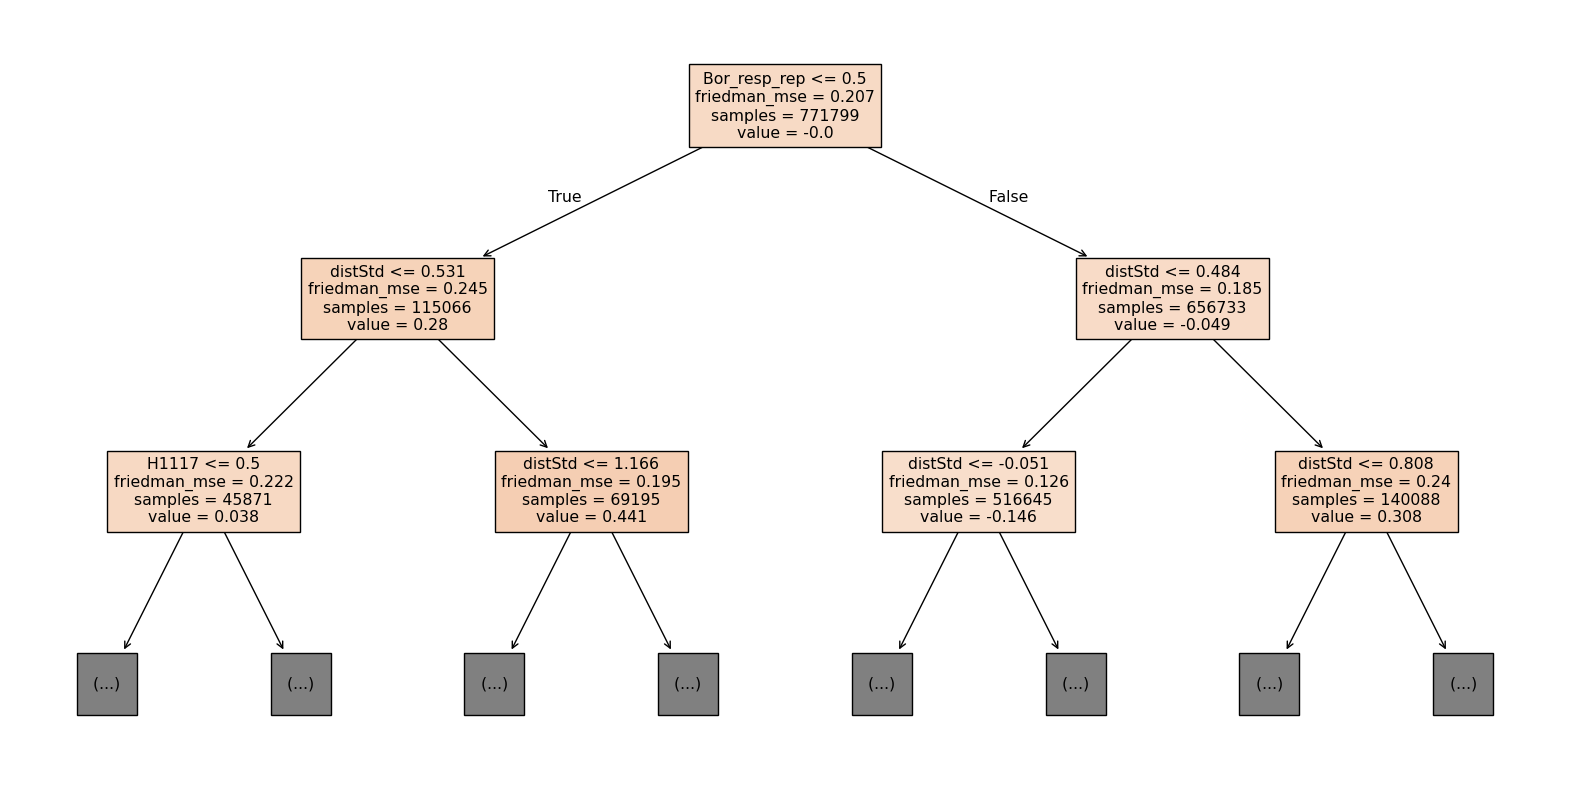

In [ ]:
# Visualiser les 3 premiers niveaux de l'arbre dans le modèle GradientBoosting
plt.figure(figsize=(20,10))
plot_tree(gb_model2.estimators_[0, 0], # arbre #1
          filled=True,
          feature_names=X_train.columns,
          max_depth=2)  # Limiter à 3 niveaux
plt.show()


Dans ce premier arbre, la première séparation se fait sur la variable `Bor_resp_rep` qui est une variable binaire représentant si la caserne déployée (répondante) et la caserne responsable sont dans le même arrondissement (1 = oui, 0 = non). </br>
Au second niveau, les deux noeuds se séparent en branches supplémentaires selon la même variable : la distance standardisée (`distStd`). La borne est légèrement différente si la caserne répondante et la caserne déployée sont identiques (`distStd<=0.531` *versus* `distStd=0.484`). La distance a aussi beaucoup de poids sur le troisième niveau de l'arbre car elle intervient dans 3 tests sur 4.

In [ ]:
n_nodes = gb_model2.estimators_[0, 0].tree_.node_count
count_dist=0
count_bor_rr=0
for i in np.arange(0,n_nodes):
    if (gb_model2.estimators_[0, 0].tree_.feature[i]==48):
        count_dist = count_dist+1
    if (gb_model2.estimators_[0, 0].tree_.feature[i]==2):
        count_bor_rr = count_bor_rr+1

print("nombre de noeuds dans l'arbre #100:", n_nodes)
print("nombre de tests impliquant distStd :", count_dist, "soit (",
      np.round(100*count_dist/n_nodes, 1), "%)")
print("nombre de tests impliquant Bor_resp_rep :", count_bor_rr, "soit (",
      np.round(100*count_bor_rr/n_nodes, 1), "%)")

nombre de noeuds dans l'arbre #100: 617
nombre de tests impliquant distStd : 102 soit ( 16.5 %)
nombre de tests impliquant Bor_resp_rep : 1 soit ( 0.2 %)


Sur la totalité de l'arbre n°1, la variable `distStd` apparaît 102 fois (soit dans 16,5% des noeuds de l'abre) alors que `Bor_resp_rep` n'apparaît que lors du premier test.

#### Arbre n°100

Dans l'arbre correspondant à la 100ème itération de l'algorithme de Gradient Boosting, le premier noeud est construit en fonction de la variable `Stat_resp_rep` qui indique si la caserne répondante est la même que la caserne responsable (1= oui, 0 = non). Cette variable explicative n'apparaît pas dans les 3 premiers niveaux de l'arbre n°1 tout comme `H26` (variable binaire vaut 1 si l'incident à lieu entre 2 et 6h) et `PropCat_Outdoor` (top sur le lieu de l'incident vaut 1 s'il est en extérieur)

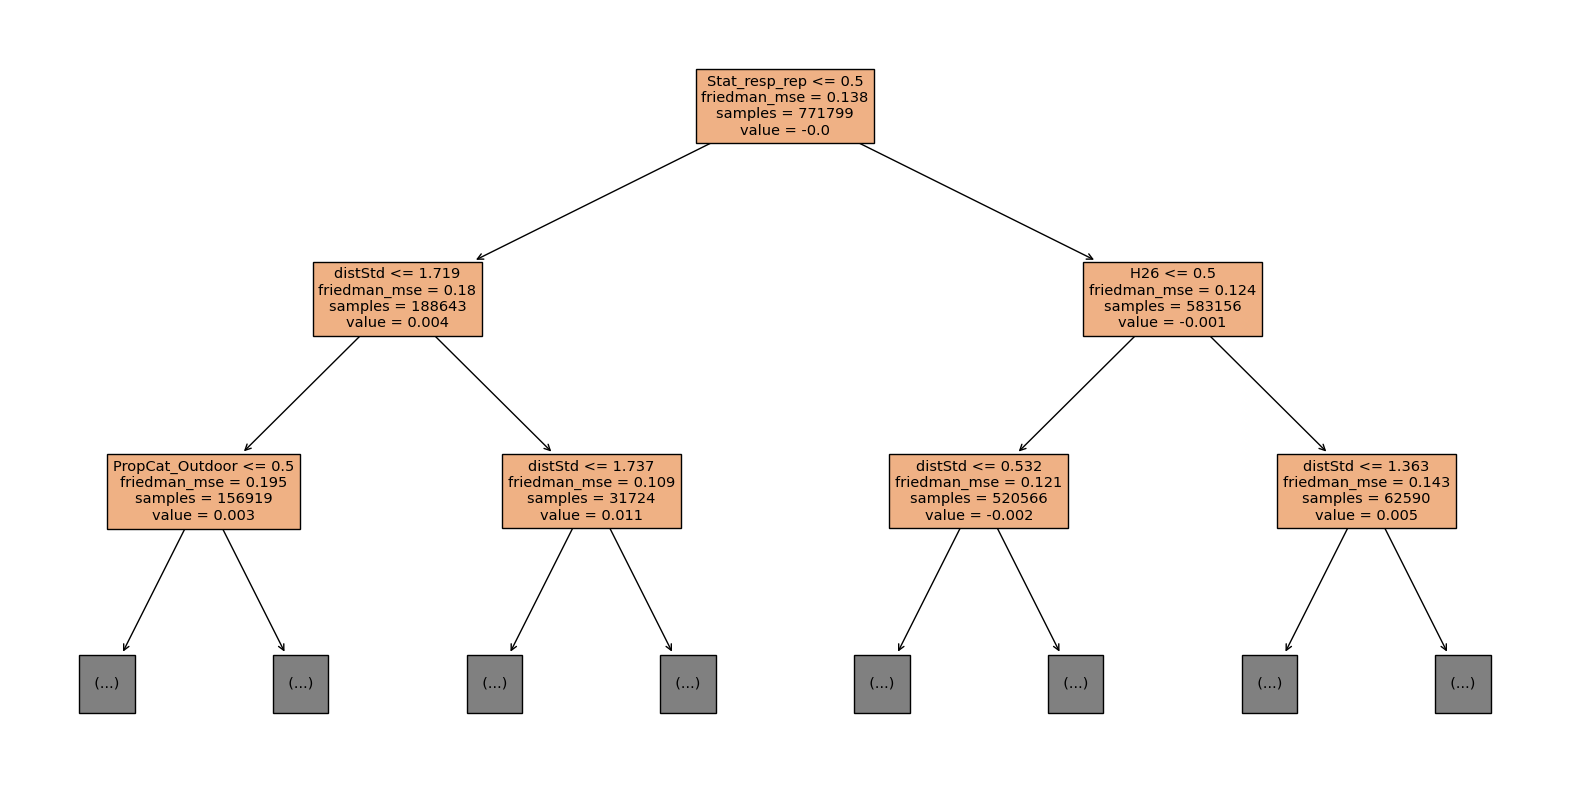

In [ ]:
# Visualiser les 3 premiers niveaux de l'arbre dans le modèle GradientBoosting
plt.figure(figsize=(20,10))
plot_tree(gb_model2.estimators_[99, 0], # arbre #100
          filled=True,
          feature_names=X_train.columns,
          max_depth=2)  # Limiter à 3 niveaux
plt.show()


In [ ]:
n_nodes = gb_model2.estimators_[99, 0].tree_.node_count
count_dist=0
count_bor_rr=0
for i in np.arange(0,n_nodes):
    if (gb_model2.estimators_[99, 0].tree_.feature[i]==48):
        count_dist = count_dist+1
    if (gb_model2.estimators_[99, 0].tree_.feature[i]==2):
        count_bor_rr = count_bor_rr+1

print("nombre de noeuds dans l'arbre #100:", n_nodes)
print("nombre de tests impliquant distStd :", count_dist, "soit (",
      np.round(100*count_dist/n_nodes, 1), "%)")
print("nombre de tests impliquant Bor_resp_rep :", count_bor_rr, "soit (",
      np.round(100*count_bor_rr/n_nodes, 1), "%)")

nombre de noeuds dans l'arbre #100: 281
nombre de tests impliquant distStd : 55 soit ( 19.6 %)
nombre de tests impliquant Bor_resp_rep : 2 soit ( 0.7 %)


Sur la totalité de l'arbre n°100, la variable `distStd` apparaît 55 fois (soit dans 19,6% des noeuds de l'abre) et `Bor_resp_rep` deux.

#### Arbre n°200

Certaines des variables explicatives apparaissant dans l'arbre n°200 sont encore différentes. Comme pour les arbres précédents, la variable `distStd` apparaît souvent dans les tests.

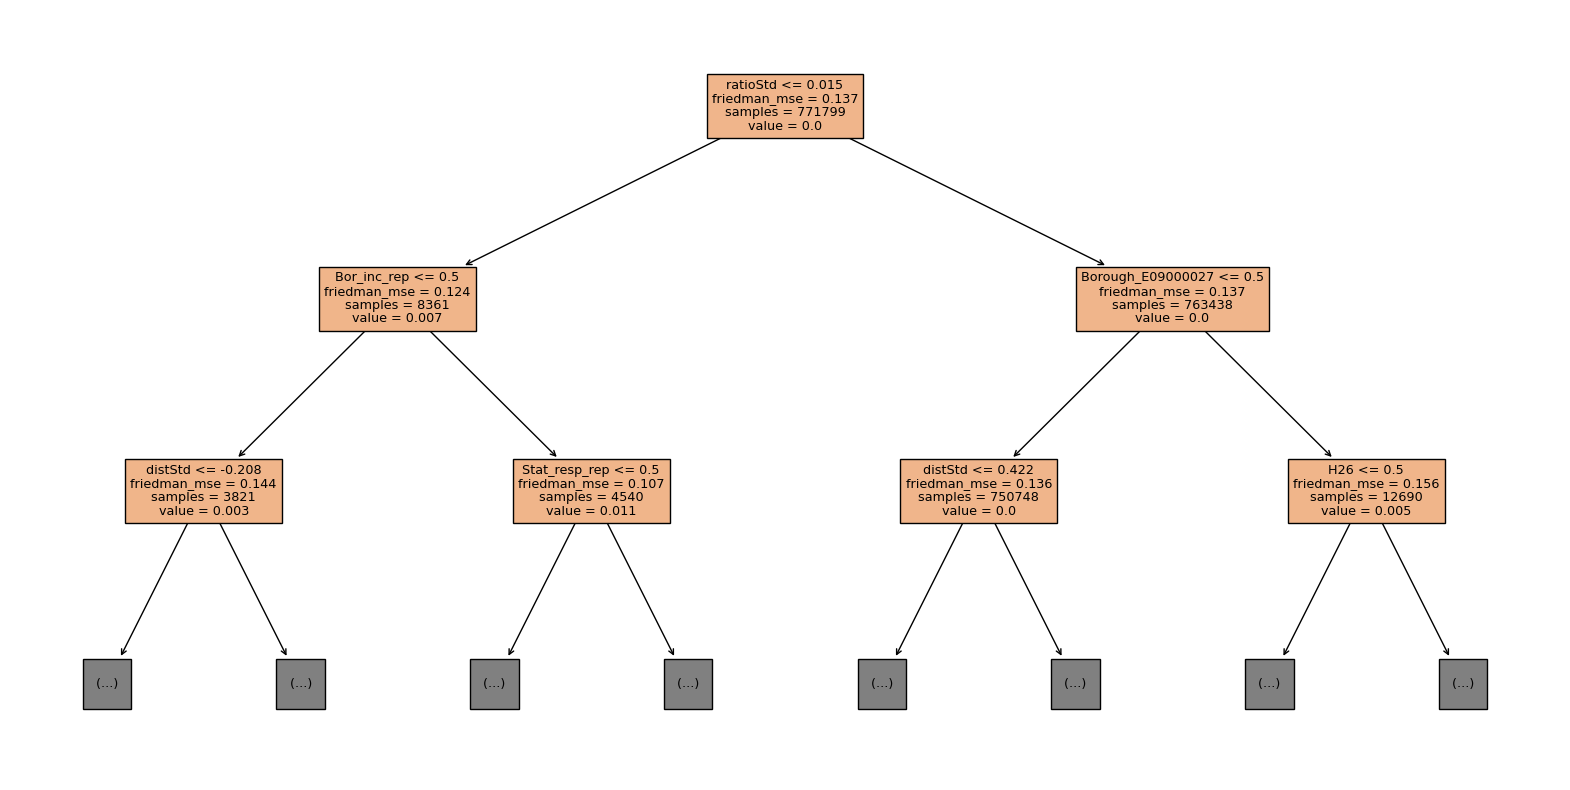

In [ ]:
# Visualiser les 3 premiers niveaux de l'arbre dans le modèle GradientBoosting
plt.figure(figsize=(20,10))
plot_tree(gb_model2.estimators_[199, 0], # arbre #100
          filled=True,
          feature_names=X_train.columns,
          max_depth=2)  # Limiter à 3 niveaux
plt.show()


In [ ]:
n_nodes = gb_model2.estimators_[199, 0].tree_.node_count
count_dist=0
count_bor_rr=0
for i in np.arange(0,n_nodes):
    if (gb_model2.estimators_[199, 0].tree_.feature[i]==48):
        count_dist = count_dist+1
    if (gb_model2.estimators_[199, 0].tree_.feature[i]==2):
        count_bor_rr = count_bor_rr+1

print("nombre de noeuds dans l'arbre #200:", n_nodes)
print("nombre de tests impliquant distStd :", count_dist, "soit (",
      np.round(100*count_dist/n_nodes, 1), "%)")
print("nombre de tests impliquant Bor_resp_rep :", count_bor_rr, "soit (",
      np.round(100*count_bor_rr/n_nodes, 1), "%)")

nombre de noeuds dans l'arbre #200: 201
nombre de tests impliquant distStd : 46 soit ( 22.9 %)
nombre de tests impliquant Bor_resp_rep : 5 soit ( 2.5 %)


### Importance des variables explicatives

Comme vu précédemment (dans le modèle choisi et dans la plupart des modèles de ce notebook), parmi les 50 variables explicatives, la plus importante est `distStd`. Vient ensuite la variable `Stat_resp_rep` avec une moindre importance. L'importance décroit rapidement dès les 5 premières variables.

In [ ]:
feat_imp = pd.DataFrame({'importance': gb_model2.feature_importances_}, index=gb_model2.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

importance
distStd              0.679640
Stat_resp_rep        0.140097
ratioStd             0.038667
Bor_resp_rep         0.038607
Bor_inc_rep          0.012194
inner                0.009532
H26                  0.009176
PropCat_Outdoor      0.007013
Borough_E09000022    0.006739
H1117                0.006316

La variable avec le moins d'importance dans le modèle est `PropCat_Boat` (variable binaire indiquant si le lieu de l'incident est un bateau).

In [ ]:
feat_imp = pd.DataFrame({'importance': gb_model2.feature_importances_}, index=gb_model2.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=True).head(10)

importance
PropCat_Boat            0.000231
Borough_E09000020       0.000339
PropCat_Aircraft        0.000351
Borough_E09000001       0.000375
Borough_E09000031       0.000380
Borough_E09000019       0.000406
Borough_E09000012       0.000468
Borough_E09000004       0.000470
PropCat_Rail Vehicle    0.000474
Borough_E09000006       0.000524

### Shap Values

In [ ]:
gb_model2 = GradientBoostingClassifier(n_estimators=400, learning_rate=0.046415888336,
                                       subsample=0.875, min_samples_split=0.0005, max_depth=9,
                                       max_features=25, random_state=42)
ypred_train_gb2, ypred_test_gb2 = train_and_evaluate_model(gb_model2, "Optimized Gradient Boosting #2", X_train, y_train, X_test, y_test)

Optimized Gradient Boosting #2

Train Dataset
accuracy : 0.8097
precision : [0.8322 0.7311]
recall : [0.915  0.5561]
f1 score : [0.8717 0.6317]
ROC AUC : 0.7356



Test Dataset
accuracy : 0.8049
precision : [0.8281 0.7236]
recall : [0.9129 0.5461]
f1 score : [0.8685 0.6224]
ROC AUC : 0.7295


Afin de comprendre comment les variables explicatives influencent la prédiction, nous avons calculé leur importance via les valeurs SHAP qui peuvent ensuite être représentées graphiquement. Les valeurs SHAP sont calculées en considérant toutes les variables du modèle et en évaluant leur contribution marginale à la prédiction de chaque observation. Dans le cas d'un modèle comme le Gradient Boosing qui combine un ensemble d'arbres faibles (400 pour notre modèle), les valeurs SHAP sont calculées pour chacun des arbres. Ces valeurs sont ensuite combinées en fonction du poids de chaque arbre dans le modèle "global" afin d'obtenir une valeur SHAP par couple caractéristique (=variable explicative) / observations.

In [ ]:
# Création de l'explainer pour votre modèle Gradient Boosting
explainer_shap = shap.TreeExplainer(gb_model2)

# Calcul des valeurs SHAP pour les instances de test
shap_values = explainer_shap.shap_values(X_test)

Les graphiques ci-dessous représentent l'ensemble des valeurs SHAP pour les prédictions du modèle liées aux observations du jeu de données test. L'axe des x représente la valeur SHAP, tandis que l'axe des y liste les 10 plus / moins  importantes variables explicatives (pour le premier / second graphique). La couleur rouge indique une valeur élevée de la variable explicative, tandis que le bleu indique une valeur basse.

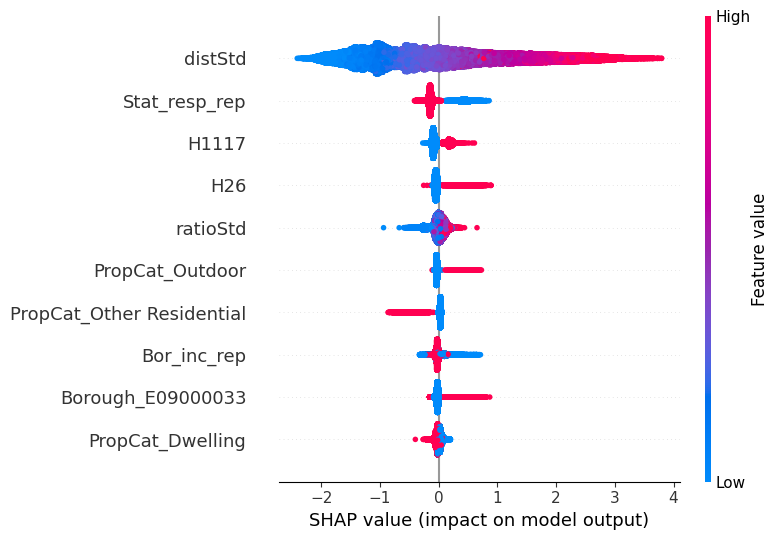

In [ ]:
# Afficher le résumé SHAP pour les 10 premières caractéristiques
shap.summary_plot(shap_values, X_test, max_display=10)

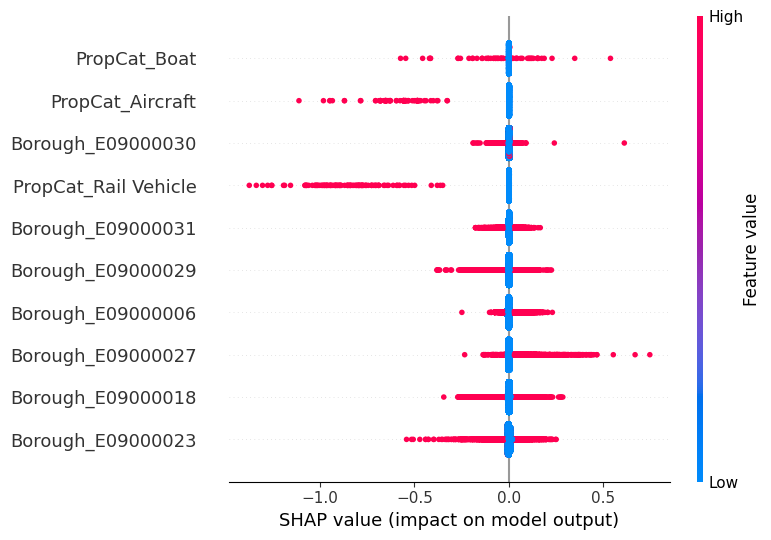

In [ ]:
# Nous calculons l'importance des caractéristiques en prenant la valeur absolue de la somme des valeurs SHAP pour chaque caractéristique
importance = np.abs(shap_values).mean(axis=0)

# Indices des 10 caractéristiques les moins importantes
flop_10_idx = np.argsort(importance)[0:10]

# Filtrer les SHAP values et X_test pour ne conserver que les 10 dernières caractéristiques
shap_values_flop_10 = shap_values[:, flop_10_idx]
X_test_flop_10 = X_test.iloc[:, flop_10_idx]

# Afficher le résumé SHAP pour les 10 premières caractéristiques
# avec sort=False, l'ordre des features sera celui de flop_10_idx = importance croissante en partant de la moins importante
shap.summary_plot(shap_values_flop_10, X_test_flop_10, sort=False)

***Nota Bene*** </br>
On constate que l'ordre d'importance des variables via les valeurs SHAP est légèrement différent de celui vu précédement et défini dans l'attribut `feature_importances_` du modèle de Gradient Boosting.

Dans l'attribut `feature_importances_`, les valeurs d'importance sont calculées en fonction de la réduction de l'erreur au cours de l'entraînement du modèle. C'est une métrique "globale". Plus l'impact d'une variable explicative sur la réduction de l'erreur est fort, plus forte est la valeur de `feature_importances_`.

Comme expliqué précédemment, les valeurs SHAP sont calculées en considérant toutes les variables du modèle et en évaluant leur contribution marginale à la prédiction de chaque observation. De plus, nous utilison la valeur absolue de la moyenne des valeurs SHAP pour déterminer l'importance des variables explicatives.

**Interprétation du graphique de Shappley**

- La distance standardisée `distStd` est la variable la plus importante. Si la distance est faible (SHAP values négatives), la valeur prédite l'est aussi ce qui correspond à temps d'intervention  inférieur à 6 min. On constate aussi l'inverse. Il est cohérent qu'une distance plus longue implique un temps de trajet plus long.

- Graphiquement, les valeurs fortes de `Stat_resp_rep` sont associées à de faibles valeurs SHAP. Autrement dit, lorsque la caserne responsable est celle qui répond à l'incident (`Stat_resp_rep=1`), il y a plus de chance que le temps d'intervention soit inférieur à 6 minutes. Cette influence s'explique car si la caserne déployée (répondante) n'est pas la caserne responsable cela implique sûrement une distance plus importante.

- Les observations où `H1117=1` / `H26=1` sont associées à des valeurs SHAP élevées. Autrement dit, il y a plus de chance que le temps d'intervention soit supérieur à 6 minutes si l'incident a lieu sur les plages horaires [2 - 6] et [11 - 17].  Pour la plage horaire nocturne, cela s'explique par une faible mobilisation (heures creuses, moins de pompiers présents en caserne). Pour l'autre plage, on peut supposer que la densité importante du trafic routier augmente le temps de trajet.

- Des valeurs fortes de `ratioStd` sont associées à des valeurs SHAP élevées. Pour rappel `ratioStd` représente le ratio entre la superficie d'un arrondissement et le nombre de casernes dans celui-ci. Il y a donc plus de chance que le temps d'intervention soit supérieur à 6 minutes quand cette densité est forte. On peut supposer que moins il y a de casernes au kilometre carré (densité forte), plus la caserne a de distance à parcourir pour agir et donc plus le temps de trajet est long.

- les variables `PropCat_Outdoor`, `PropCat_Other Residential` et `PropCat_Dwelling` - qui précisent le type de localisation de l'incident - influencent la prédiction du modèle de façon positive pour la première et négative pour les deux autres. Autrement dit, si un incident a lieu en extérieur (`PropCat_Outdoor=1`, forte valeur), il y a plus de chance que le temps de trajet soit supérieur à 6 minutes ; c'est l'inverse si l'incident a lieu chez un particulier (Dwelling) ou dans un autre type de résidence (temps de trajet de moins de 6 minutes plus probable).

- à l'exception de `PropCat_Aircraft` et `PropCat_Rail_Vehicle`, il est plus difficile de commenter les graphiques des 10 variables les moins influentes car les valeurs SHAP positives / négatives ne sont pas associées à une seule valeur de ces variables explicatives binaires. Par exemple, `PropCat_Aircraft=0` est associé à des valeurs SHAP proches de 0 alors que `PropCat_Aircraft=1` est associé de valeurs de SHAP de de -0,5 à +0,5 dont la majorité est centrée sur 0.

- Les variables `PropCat_Aircraft` et `PropCat_Rail_Vehicle` - qui indiquent que l'incident a lieu dans un avion ou un train (ou tout appareil similaire) - influencent la prédiction du modèle négativement (forte valeur de la caractéristique associée à des faibles valeurs SHAP). Autrement dit, si un incident a lieu dans un avion / train, il y a plus de chance que le temps de trajet soit inférieur à 6 minutes. Cela s'explique sans doute par la dangerosité de ces incidents et/ou la présence d'humains dans l'avion / le train impliqué.


## <font color='blue'>4.b) Interprétation locale </font>

Etudier l'interprétabilité au niveau local permet de comprendre comment le modèle prédit la réponse à l'aide des différentes variables explicatives pour une observation spécifique. Pour illustrer cette interprétabilité nous avons étudié quatre incidents avec un temps de réponse réel / prédit inférieur ou supérieur à 0.

In [ ]:
# choix des incidents en comparant observations et prédictions
display(y_test.iloc[[0,1,2,15],]) # dans l'ordre, 2 incidents avec un temps de réponse > 6 min puis 2 avec temps >6
print("prédiction :", ypred_test_gb2[[0,1,2,15]]) # prédiction correspondant à l'observation pour les lignes numérotées 1 et 2

ResponseTimeBinary
0                    1
1                    1
2                    0
15                   0

[0 1 0 1]


### Library Shap

In [ ]:
shap.initjs()

print("incident avec un temps (réel > 6 minutes)")
print("prédiction correcte")
display(shap.force_plot(explainer_shap.expected_value, shap_values[1, :], X_test.iloc[1, :]))
print("prédiction incorrecte")
display(shap.force_plot(explainer_shap.expected_value, shap_values[0, :], X_test.iloc[0, :]))

print("incident avec un temps (réel < 6 minutes)")
print("prédiction correcte")
display(shap.force_plot(explainer_shap.expected_value, shap_values[2, :], X_test.iloc[2, :]))
print("prédiction incorrecte")
display(shap.force_plot(explainer_shap.expected_value, shap_values[15, :], X_test.iloc[15, :]))



incident avec un temps (réel > 6 minutes)
prédiction correcte


prédiction incorrecte


incident avec un temps (réel < 6 minutes)
prédiction correcte


prédiction incorrecte


- Incident n°1 (observation = prédiction = temps d'intervention supérieur à 6 minutes) : La variable `H1117=0` est la principale variable avec une contribution négative au modèle alors que `distStd=1.244` `H26=1`, `Stat_resp_rep=0` et `Borough_E09000028=1` sont les principales avec une contribution positive. Ces observations sont cohérentes avec nos conclusions de l'interprétabilité global : le fait que l'incident ait eu lieu sur la plage horaire nocturne [2-6] et que la caserne déployée ne soit pas la caserne responsable influence la prédiction vers la valeur positive (`ResponseTimeBinary` prédit à 1).

- Incident n°0 (observation : temps d'intervention supérieur à 6 minutes, prédiction incorrecte) : les variables  `distStd=-0.1353`, `Stat_resp_rep=1`, `H26=0` et `H1117=0` ont une contribution négative suffisante pour que la prédiction soit négative (temps d'intervention inférieur à 6 minutes) alors que la valeur observée est positive.

- Incident n°2 (observation = prédiction = temps d'intervention inférieur à 6 minutes) : la contribution négative des variables  `distStd=-0.01524` et `H1117=0` est suffisante pour contrebalancer la contribution positive des variables `H26=1`, `Stat_resp_rep=0` et `Borough_E09000028=1`.

- Incident n°15 (observation : temps d'intervention inférieur à 6 minutes, prédiction incorrecte) : la contribution négative de la variable  `H1117=0` n'est pas suffisante pour contrebalancer la contribution positive des variables `distStd=0.6656`, `Stat_resp_rep=0`, `Bor_inc_rep=0`, `Bor_resp_rep=0`.

### Library Lime

Tout comme `shap`, la librairie python `lime` est très utilisée en machine learning. Contrairement à shap, lime s'applique uniquement à l'interprétabilité locale car il s'agit d'appliquer une approximation du modèle à une observation spécifique. Nous avons repris les 4 incidents précédents et les avons analysés avec lime. Le fonctionnement entre `shap` et `lime`, il peut y avoir des écarts d'interprétation etnre les 2 méthodes.

In [ ]:
# Récupération de explainer Lime
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(),
                                              mode="classification",
                                              feature_names= list(X_train.columns)
                                              )

##### Incident n°1 (obs=1 et pred=1)

In [ ]:
# Choisir une instance à expliquer (par exemple, la première instance du jeu de test)
explanation = explainer_lime.explain_instance(X_test.values[1], gb_model2.predict_proba)

# Afficher l'explication dans le notebook
explanation.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names



Le graphique ci-dessus explique la prédiction de l'incident n°1 du jeu de donnée test. Le modèle prédit avec une probabilité de 74% que le temps d'intervention est supérieur à 6 minutes, ce qui correspond à la réalité. La variable la plus influente est `distStd` avec un poids de 0,58 (contribution positive). C'est la seule variable qui apparaît à la fois sur le graphique shap et lime.

##### Incident n°0 (obs=1 et pred=0)

In [ ]:
# Choisir une instance à expliquer (par exemple, la première instance du jeu de test)
explanation = explainer_lime.explain_instance(X_test.values[0], gb_model2.predict_proba)

# Afficher l'explication dans le notebook
explanation.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names



Le graphique ci-dessus explique la prédiction de l'incident n°0 du jeu de donnée test. Le modèle prédit avec une probabilité de 80% que le temps d'intervention est inférieur à 6 minutes alors qu'il est supérieur dans la réalité. La variable la plus influente est de nouveau `distStd` avec un poids de 0,23 (contribution négative). La variable `PropCat_Outdoor` apparaît aussi sur le graphique shap et a un impact positif de 0,08.

##### Incident n°2 (obs=0 et pred=0)

In [ ]:
# Choisir une instance à expliquer (par exemple, la première instance du jeu de test)
explanation = explainer_lime.explain_instance(X_test.values[2], gb_model2.predict_proba)

# Afficher l'explication dans le notebook
explanation.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names



Le graphique ci-dessus explique la prédiction de l'incident n°2 du jeu de donnée test. Le modèle prédit avec une probabilité de 63% que le temps d'intervention est inférieur à 6 minutes, ce qui correspond à la réalité. La variable la plus influente est une foie encore `distStd` avec un poids de 0,24 (contribution négative). C'est la seule variable qui apparaît à la fois sur le graphique shap et lime.

##### Incident n°2 (obs=0 et pred=1)

In [ ]:
# Choisir une instance à expliquer (par exemple, la première instance du jeu de test)
explanation = explainer_lime.explain_instance(X_test.values[15], gb_model2.predict_proba)

# Afficher l'explication dans le notebook
explanation.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names



Le graphique ci-dessus explique la prédiction de l'incident n°0 du jeu de donnée test. Le modèle prédit avec une probabilité de 62% que le temps d'intervention est supérieur à 6 minutes alors qu'il est inférieur dans la réalité. La variable la plus influente est de nouveau `distStd` avec un poids de 0,58 (contribution positive). C'est la seule variable qui apparaît à la fois sur le graphique shap et lime.